In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.layers import LSTM, Dense, Dropout, MultiHeadAttention, LayerNormalization
pd.set_option('display.max_columns', None)

In [2]:
! pip install mplfinance
! pip install pandas_ta

In [3]:
eurusd = pd.read_csv('/kaggle/input/forex/EURUSD-60-DS.csv')

# دیتافریم‌های جدید
audusd = pd.read_csv('/kaggle/input/forex/AUDUSD-60-DS.csv', header=None, names=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
gbpusd = pd.read_csv('/kaggle/input/forex/GBPUSD-60-DS.csv', header=None, names=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
usdcad = pd.read_csv('/kaggle/input/forex/USDCAD-60-DS.csv', header=None, names=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

In [4]:
for df in [eurusd, audusd, gbpusd, usdcad]:
    df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y %H:%M:%S.%f')

In [5]:
# تنظیم Date به‌عنوان ایندکس
eurusd.set_index('Date', inplace=True)
audusd.set_index('Date', inplace=True)
gbpusd.set_index('Date', inplace=True)
usdcad.set_index('Date', inplace=True)

In [6]:
eurusd = eurusd.add_prefix('EURUSD_')
audusd = audusd.add_prefix('AUDUSD_')
gbpusd = gbpusd.add_prefix('GBPUSD_')
usdcad = usdcad.add_prefix('USDCAD_')
df = eurusd.join([audusd, gbpusd, usdcad], how='inner')

In [7]:
import pandas as pd
import numpy as np
import pandas_ta as ta



# لیست جفت‌ارزها
currency_pairs = ['EURUSD', 'AUDUSD', 'GBPUSD', 'USDCAD']

# تابع برای محاسبه اندیکاتورها برای هر جفت‌ارز
def add_technical_indicators(df, pair, period=14):
    # پیشوند ستون‌ها
    prefix = f"{pair}_"
    
    # ATR
    df[f'atr_14_{pair}'] = ta.atr(df[f'{pair}_High'], df[f'{pair}_Low'], df[f'{pair}_Close'], length=period)
    
    # Bollinger Bands
    bb = ta.bbands(df[f'{pair}_Close'], length=period, std=2)
    bb.columns = [col.replace(f'_{period}_2.0', f'_{pair}') for col in bb.columns]
    df = pd.concat([df, bb], axis=1)
    
    # ADX و DMI
    adx_data = ta.adx(df[f'{pair}_High'], df[f'{pair}_Low'], df[f'{pair}_Close'], length=period)
    df[f'DMI_PLUS_{pair}'] = adx_data[f'DMP_{period}']
    df[f'DMI_MINUS_{pair}'] = adx_data[f'DMN_{period}']
    df[f'ADX_{pair}'] = adx_data[f'ADX_{period}']
    df[f'ADXR_{pair}'] = (df[f'ADX_{pair}'] + df[f'ADX_{pair}'].shift(period)) / 2
    
    # EMAVG
    df[f'EMAVG_{pair}'] = ta.ema(df[f'{pair}_Close'], length=period)
    
    # MIN و MAX
    df[f'MIN_{pair}'] = df[f'{pair}_Low'].rolling(window=period).min()
    df[f'MAX_{pair}'] = df[f'{pair}_High'].rolling(window=period).max()
    
    # MOMENTUM
    df[f'MOMENTUM_{pair}'] = ta.mom(df[f'{pair}_Close'], length=period)
    df[f'MOM_MA_{pair}'] = ta.sma(df[f'MOMENTUM_{pair}'], length=period)
    
    # MACD
    macd = ta.macd(df[f'{pair}_Close'], fast=12, slow=26, signal=9)
    macd.columns = [col + f'_{pair}' for col in macd.columns]
    df = pd.concat([df, macd], axis=1)
    
    # Moving Average Envelopes
    mae = ta.ema(df[f'{pair}_Close'], length=period)
    df[f'MAE_MIDDLE_{pair}'] = mae
    df[f'MAE_UPPER_{pair}'] = mae * 1.05
    df[f'MAE_LOWER_{pair}'] = mae * 0.95
    
    # ROC
    df[f'ROC_{pair}'] = ta.roc(df[f'{pair}_Close'], length=period)
    
    # RSI
    df[f'rsi_14_{pair}'] = ta.rsi(df[f'{pair}_Close'], length=period)
    
    # SMAVG
    df[f'SMAVG_{pair}'] = ta.sma(df[f'{pair}_Close'], length=period)
    
    # Stochastic
    stoch = ta.stoch(df[f'{pair}_High'], df[f'{pair}_Low'], df[f'{pair}_Close'], k=period, d=3, smooth=3)
    stoch.columns = [col + f'_{pair}' for col in stoch.columns]
    df = pd.concat([df, stoch], axis=1)
    
    # TMAVG (Triangular Moving Average)
    df[f'TMAVG_{pair}'] = ta.trima(df[f'{pair}_Close'], length=period)
    
    # WMAVG (Weighted Moving Average)
    df[f'WMAVG_{pair}'] = ta.wma(df[f'{pair}_Close'], length=period)
    
    # Williams %R
    df[f'WLPR_{pair}'] = ta.willr(df[f'{pair}_High'], df[f'{pair}_Low'], df[f'{pair}_Close'], length=period)
    
    # OBV
    df[f'obv_{pair}'] = ta.obv(df[f'{pair}_Close'], df[f'{pair}_Volume'])
    
    # سایر اندیکاتورها
    df[f'high_low_diff_{pair}'] = df[f'{pair}_High'] - df[f'{pair}_Low']
    df[f'std_60_{pair}'] = df[f'{pair}_Close'].rolling(window=60).std()
    df[f'cci_14_{pair}'] = ta.cci(df[f'{pair}_High'], df[f'{pair}_Low'], df[f'{pair}_Close'], length=period)
    df[f'upper_shadow_{pair}'] = df[f'{pair}_High'] - df[[f'{pair}_Open', f'{pair}_Close']].max(axis=1)
    df[f'lower_shadow_{pair}'] = df[[f'{pair}_Open', f'{pair}_Close']].min(axis=1) - df[f'{pair}_Low']
    
    return df

# تنظیم دوره پیش‌فرض
period = 14

# اضافه کردن اندیکاتورها برای همه جفت‌ارزها
for pair in currency_pairs:
    df = add_technical_indicators(df, pair, period)

# اندیکاتورهای اضافی مستقل از جفت‌ارز (مثل زمان)
df['weekday'] = df.index.weekday
df['hour'] = df.index.hour

# حذف مقادیر NaN
df = df.dropna()

# نمایش چند ردیف اول
df.head()

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73:

,EURUSD_Open,EURUSD_High,EURUSD_Low,EURUSD_Close,EURUSD_Volume,AUDUSD_Open,AUDUSD_High,AUDUSD_Low,AUDUSD_Close,AUDUSD_Volume,GBPUSD_Open,GBPUSD_High,GBPUSD_Low,GBPUSD_Close,GBPUSD_Volume,USDCAD_Open,USDCAD_High,USDCAD_Low,USDCAD_Close,USDCAD_Volume,atr_14_EURUSD,BBL_EURUSD,BBM_EURUSD,BBU_EURUSD,BBB_EURUSD,BBP_EURUSD,DMI_PLUS_EURUSD,DMI_MINUS_EURUSD,ADX_EURUSD,ADXR_EURUSD,EMAVG_EURUSD,MIN_EURUSD,MAX_EURUSD,MOMENTUM_EURUSD,MOM_MA_EURUSD,MACD_12_26_9_EURUSD,MACDh_12_26_9_EURUSD,MACDs_12_26_9_EURUSD,MAE_MIDDLE_EURUSD,MAE_UPPER_EURUSD,MAE_LOWER_EURUSD,ROC_EURUSD,rsi_14_EURUSD,SMAVG_EURUSD,STOCHk_14_3_3_EURUSD,STOCHd_14_3_3_EURUSD,TMAVG_EURUSD,WMAVG_EURUSD,WLPR_EURUSD,obv_EURUSD,high_low_diff_EURUSD,std_60_EURUSD,cci_14_EURUSD,upper_shadow_EURUSD,lower_shadow_EURUSD,atr_14_AUDUSD,BBL_AUDUSD,BBM_AUDUSD,BBU_AUDUSD,BBB_AUDUSD,BBP_AUDUSD,DMI_PLUS_AUDUSD,DMI_MINUS_AUDUSD,ADX_AUDUSD,ADXR_AUDUSD,EMAVG_AUDUSD,MIN_AUDUSD,MAX_AUDUSD,MOMENTUM_AUDUSD,MOM_MA_AUDUSD,MACD_12_26_9_AUDUSD,MACDh_12_26_9_AUDUSD,MACDs_12_26_9_AUDUSD,MAE_MIDDLE_AUDUSD,MAE_UPPER_AUDUSD,MAE_LOWER_AUDUSD,ROC_AUDUSD,rsi_14_AUDUSD,SMAVG_AUDUSD,STOCHk_14_3_3_AUDUSD,STOCHd_14_3_3_AUDUSD,TMAVG_AUDUSD,WMAVG_AUDUSD,WLPR_AUDUSD,obv_AUDUSD,high_low_diff_AUDUSD,std_60_AUDUSD,cci_14_AUDUSD,upper_shadow_AUDUSD,lower_shadow_AUDUSD,atr_14_GBPUSD,BBL_GBPUSD,BBM_GBPUSD,BBU_GBPUSD,BBB_GBPUSD,BBP_GBPUSD,DMI_PLUS_GBPUSD,DMI_MINUS_GBPUSD,ADX_GBPUSD,ADXR_GBPUSD,EMAVG_GBPUSD,MIN_GBPUSD,MAX_GBPUSD,MOMENTUM_GBPUSD,MOM_MA_GBPUSD,MACD_12_26_9_GBPUSD,MACDh_12_26_9_GBPUSD,MACDs_12_26_9_GBPUSD,MAE_MIDDLE_GBPUSD,MAE_UPPER_GBPUSD,MAE_LOWER_GBPUSD,ROC_GBPUSD,rsi_14_GBPUSD,SMAVG_GBPUSD,STOCHk_14_3_3_GBPUSD,STOCHd_14_3_3_GBPUSD,TMAVG_GBPUSD,WMAVG_GBPUSD,WLPR_GBPUSD,obv_GBPUSD,high_low_diff_GBPUSD,std_60_GBPUSD,cci_14_GBPUSD,upper_shadow_GBPUSD,lower_shadow_GBPUSD,atr_14_USDCAD,BBL_USDCAD,BBM_USDCAD,BBU_USDCAD,BBB_USDCAD,BBP_USDCAD,DMI_PLUS_USDCAD,DMI_MINUS_USDCAD,ADX_USDCAD,ADXR_USDCAD,EMAVG_USDCAD,MIN_USDCAD,MAX_USDCAD,MOMENTUM_USDCAD,MOM_MA_USDCAD,MACD_12_26_9_USDCAD,MACDh_12_26_9_USDCAD,MACDs_12_26_9_USDCAD,MAE_MIDDLE_USDCAD,MAE_UPPER_USDCAD,MAE_LOWER_USDCAD,ROC_USDCAD,rsi_14_USDCAD,SMAVG_USDCAD,STOCHk_14_3_3_USDCAD,STOCHd_14_3_3_USDCAD,TMAVG_USDCAD,WMAVG_USDCAD,WLPR_USDCAD,obv_USDCAD,high_low_diff_USDCAD,std_60_USDCAD,cci_14_USDCAD,upper_shadow_USDCAD,lower_shadow_USDCAD,weekday,hour
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-01-04 14:00:00,1.47133,1.47179,1.46954,1.47110,40883.4065,0.87609,0.87627,0.87397,0.87427,1.209640e+09,1.97705,1.97730,1.97345,1.97475,15001.7921,0.98745,0.99015,0.98740,0.98750,7.007980e+09,0.002166,1.469372,1.472530,1.475688,0.428865,0.273561,12.356729,19.794521,18.655791,18.627751,1.472052,1.4691,1.47519,-0.00284,-0.001355,-0.000307,-0.000482,0.000175,1.472052,1.545655,1.398450,-0.192681,44.923610,1.472530,30.346693,27.604896,1.472700,1.471787,-67.159278,116480.4568,0.00225,0.003714,-76.997492,0.00046,0.00156,0.002127,0.874026,0.879419,0.884812,1.226485,0.022659,13.468160,26.153613,16.325542,18.700262,0.878424,0.87324,0.88367,-0.00442,-0.001219,-0.001255,-0.000686,-0.000568,0.878424,0.922345,0.834503,-0.503022,33.781052,0.879419,13.710451,15.834452,0.880203,0.878345,-90.124640,-6.796828e+09,0.00230,0.001977,-151.600230,0.00018,0.00030,0.003300,1.967752,1.973189,1.978626,0.551108,0.643522,23.538479,22.984383,18.471183,17.655615,1.974136,1.9673,1.98005,0.00235,-0.000850,-0.000383,0.000861,-0.001244,1.974136,2.072842,1.875429,0.119144,50.237457,1.973189,76.470588,80.041542,1.972432,1.973913,-41.568627,-20877.6849,0.00385,0.004904,68.577975,0.00025,0.00130,0.002693,0.985888,0.988345,0.990802,0.497296,0.328077,12.850246,17.334592,16.363634,17.441794,0.988514,0.98415,0.99100,-0.00085,-0.002973,-0.000883,0.000012,-0.000895,0.988514,1.037939,0.939088,-0.086002,44.561017,0.988345,60.755159,62.107451,0.988236,0.988142,-51.094891,-1.060474e+10,0.00275,0.002543,-

In [8]:
import pandas as pd
import numpy as np

# درصد تغییرات
df["pct_change_EURUSD_Close"] = df["EURUSD_Close"].pct_change()
df["pct_change_GBPUSD_Close"] = df["GBPUSD_Close"].pct_change()
df["pct_change_AUDUSD_Close"] = df["AUDUSD_Close"].pct_change()
df["pct_change_USDCAD_Close"] = df["USDCAD_Close"].pct_change()
df["pct_change_rsi_14_EURUSD"] = df["rsi_14_EURUSD"].pct_change()
df["pct_change_MACD_12_26_9_EURUSD"] = df["MACD_12_26_9_EURUSD"].pct_change()
df["pct_change_atr_14_EURUSD"] = df["atr_14_EURUSD"].pct_change()

# شتاب
df["momentum_5_EURUSD_Close"] = df["EURUSD_Close"] - df["EURUSD_Close"].shift(5)
df["momentum_10_EURUSD_Close"] = df["EURUSD_Close"] - df["EURUSD_Close"].shift(10)
df["momentum_5_rsi_14_EURUSD"] = df["rsi_14_EURUSD"] - df["rsi_14_EURUSD"].shift(5)
df["momentum_5_MACD_12_26_9_EURUSD"] = df["MACD_12_26_9_EURUSD"] - df["MACD_12_26_9_EURUSD"].shift(5)

# اندیکاتورهای پیش‌رو
df["MACD_histogram_EURUSD"] = df["MACD_12_26_9_EURUSD"] - df["MACDs_12_26_9_EURUSD"]
df["MACD_histogram_GBPUSD"] = df["MACD_12_26_9_GBPUSD"] - df["MACDs_12_26_9_GBPUSD"]
df["MACD_histogram_AUDUSD"] = df["MACD_12_26_9_AUDUSD"] - df["MACDs_12_26_9_AUDUSD"]
df["MACD_histogram_USDCAD"] = df["MACD_12_26_9_USDCAD"] - df["MACDs_12_26_9_USDCAD"]
df["DMI_diff_EURUSD"] = df["DMI_PLUS_EURUSD"] - df["DMI_MINUS_EURUSD"]
df["DMI_diff_GBPUSD"] = df["DMI_PLUS_GBPUSD"] - df["DMI_MINUS_GBPUSD"]
df["DMI_diff_AUDUSD"] = df["DMI_PLUS_AUDUSD"] - df["DMI_MINUS_AUDUSD"]
df["DMI_diff_USDCAD"] = df["DMI_PLUS_USDCAD"] - df["DMI_MINUS_USDCAD"]

# الگوهای کندل‌استیک
df["candle_body_EURUSD"] = df["EURUSD_Close"] - df["EURUSD_Open"]
df["upper_shadow_ratio_EURUSD"] = df["upper_shadow_EURUSD"] / (df["EURUSD_High"] - df["EURUSD_Low"]).replace(0, np.nan)
df["lower_shadow_ratio_EURUSD"] = df["lower_shadow_EURUSD"] / (df["EURUSD_High"] - df["EURUSD_Low"]).replace(0, np.nan)

# میانگین‌های متحرک
df["MA_diff_5_20_EURUSD"] = df["EURUSD_Close"].rolling(window=5).mean() - df["EURUSD_Close"].rolling(window=20).mean()
df["MA_diff_5_20_GBPUSD"] = df["GBPUSD_Close"].rolling(window=5).mean() - df["GBPUSD_Close"].rolling(window=20).mean()

# نوسانات
df["relative_std_5_EURUSD"] = df["EURUSD_Close"].rolling(window=5).std() / df["EURUSD_Close"].rolling(window=5).mean()
df["relative_std_5_GBPUSD"] = df["GBPUSD_Close"].rolling(window=5).std() / df["GBPUSD_Close"].rolling(window=5).mean()

# نسبت‌های جفت‌ارزها
df["EURUSD_to_GBPUSD_ratio"] = df["EURUSD_Close"] / df["GBPUSD_Close"]
df["EURUSD_to_AUDUSD_ratio"] = df["EURUSD_Close"] / df["AUDUSD_Close"]
df["EURUSD_to_USDCAD_ratio"] = df["EURUSD_Close"] / df["USDCAD_Close"]

# حذف مقادیر گمشده
df = df.dropna()

In [ ]:
import seaborn as sns
correlation_matrix = df.corr()
plt.figure(figsize=(25, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

In [ ]:
pd.options.display.max_columns = 1000
print(list(df.columns))

In [ ]:
pd.set_option('display.max_rows', None)
correlations = df.corr()['EURUSD_Close'].sort_values(ascending=False)
print(correlations)

In [9]:
features_to_keep = [
    # فیچرهای اصلی
    "EURUSD_Close",         # متغیر هدف
    "GBPUSD_Close",         # جفت‌ارز مرتبط
    "AUDUSD_Close",         # جفت‌ارز مرتبط
    "USDCAD_Close",         # جفت‌ارز مرتبط

    # فیچرهای نوسانی و اندیکاتورها برای EUR/USD
    "atr_14_EURUSD",
    "std_60_EURUSD",
    "high_low_diff_EURUSD",
    "lower_shadow_EURUSD",
    "upper_shadow_EURUSD",
    "rsi_14_EURUSD",
    "STOCHk_14_3_3_EURUSD",
    "STOCHd_14_3_3_EURUSD",
    "MACD_12_26_9_EURUSD",
    "MACDs_12_26_9_EURUSD",
    "MACDh_12_26_9_EURUSD",
    "MOMENTUM_EURUSD",
    "ADX_EURUSD",
    "DMI_PLUS_EURUSD",
    "DMI_MINUS_EURUSD",

    # فیچرهای نوسانی و اندیکاتورها برای GBP/USD
    "atr_14_GBPUSD",
    "std_60_GBPUSD",
    "high_low_diff_GBPUSD",
    "upper_shadow_GBPUSD",
    "lower_shadow_GBPUSD",
    "rsi_14_GBPUSD",
    "STOCHk_14_3_3_GBPUSD",
    "STOCHd_14_3_3_GBPUSD",
    "MACD_12_26_9_GBPUSD",
    "MACDs_12_26_9_GBPUSD",
    "MACDh_12_26_9_GBPUSD",
    "MOMENTUM_GBPUSD",
    "ADX_GBPUSD",
    "DMI_PLUS_GBPUSD",
    "DMI_MINUS_GBPUSD",

    # فیچرهای نوسانی و اندیکاتورها برای AUD/USD
    "atr_14_AUDUSD",
    "std_60_AUDUSD",
    "high_low_diff_AUDUSD",
    "upper_shadow_AUDUSD",
    "lower_shadow_AUDUSD",
    "rsi_14_AUDUSD",
    "STOCHk_14_3_3_AUDUSD",
    "STOCHd_14_3_3_AUDUSD",
    "MACD_12_26_9_AUDUSD",
    "MACDs_12_26_9_AUDUSD",
    "MACDh_12_26_9_AUDUSD",
    "MOMENTUM_AUDUSD",
    "ADX_AUDUSD",
    "DMI_PLUS_AUDUSD",
    "DMI_MINUS_AUDUSD",

    # فیچرهای نوسانی و اندیکاتورها برای USD/CAD
    "atr_14_USDCAD",
    "std_60_USDCAD",
    "high_low_diff_USDCAD",
    "upper_shadow_USDCAD",
    "lower_shadow_USDCAD",
    "rsi_14_USDCAD",
    "STOCHk_14_3_3_USDCAD",
    "STOCHd_14_3_3_USDCAD",
    "MACD_12_26_9_USDCAD",
    "MACDs_12_26_9_USDCAD",
    "MACDh_12_26_9_USDCAD",
    "MOMENTUM_USDCAD",
    "ADX_USDCAD",
    "DMI_PLUS_USDCAD",
    "DMI_MINUS_USDCAD",

    "pct_change_EURUSD_Close",
    "pct_change_GBPUSD_Close",
    "pct_change_AUDUSD_Close",
    "pct_change_USDCAD_Close",
    "pct_change_rsi_14_EURUSD",
    "pct_change_MACD_12_26_9_EURUSD",
    "pct_change_atr_14_EURUSD",
    "momentum_5_EURUSD_Close",
    "momentum_5_rsi_14_EURUSD",
    "momentum_5_MACD_12_26_9_EURUSD",
    "MACD_histogram_EURUSD",
    "DMI_diff_EURUSD",
    "DMI_diff_GBPUSD",
    "candle_body_EURUSD",
    "upper_shadow_ratio_EURUSD",
    "lower_shadow_ratio_EURUSD",
    "MA_diff_5_20_EURUSD",
    "MA_diff_5_20_GBPUSD",
    "relative_std_5_EURUSD",
    "relative_std_5_GBPUSD",
    "EURUSD_to_GBPUSD_ratio",
    "EURUSD_to_AUDUSD_ratio",
    "EURUSD_to_USDCAD_ratio",
    
    # فیچرهای زمانی
    "hour",
    "weekday"
]

In [10]:
# input_features = df.drop(['EURUSD_Open', 'EURUSD_High', 'EURUSD_Low'],axis=1).columns
scalers_inputs = {col: MinMaxScaler() for col in features_to_keep}
scaled_inputs = np.array([scalers_inputs[col].fit_transform(df[col].values.reshape(-1, 1)) for col in features_to_keep])
scaled_inputs = np.transpose(scaled_inputs, (1, 0, 2))

# 3. انتخاب تارگت (OHLC)
output_features = ['EURUSD_Close']
scalers_outputs = {col: MinMaxScaler() for col in output_features}
scaled_outputs = np.array([scalers_outputs[col].fit_transform(df[col].values.reshape(-1, 1)) for col in output_features])
scaled_outputs = np.transpose(scaled_outputs, (1, 0, 2))

In [ ]:
scaled_inputs.shape

In [11]:
def create_sequences(inputs, outputs, seq_length, forecast_horizon=1):
    X, y = [], []
    for i in range(len(inputs) - seq_length - forecast_horizon + 1):
        X.append(inputs[i:i + seq_length])  # پنجره 128 تایی از فیچرها
        y.append(outputs[i + seq_length + forecast_horizon - 1])  # مقدار آینده (t+1)
    return np.array(X), np.array(y)

seq_length = 128
forecast_horizon = 1  # پیش‌بینی برای 1 timestep آینده
X, y = create_sequences(scaled_inputs, scaled_outputs, seq_length, forecast_horizon)


# def create_sequences(inputs, outputs, seq_length, forecast_horizon=1):
#     X, y = [], []
#     for i in range(len(inputs) - seq_length - forecast_horizon + 1):
#         X.append(inputs[i:i + seq_length])  # پنجره 128 تایی از فیچرها
#         y.append(outputs[i + seq_length:i + seq_length + forecast_horizon])  # مقادیر آینده (t+1 تا t+forecast_horizon)
#     return np.array(X), np.array(y)

# seq_length = 128
# forecast_horizon = 1  # پیش‌بینی برای 5 تایم‌فریم آینده
# X, y = create_sequences(scaled_inputs, scaled_outputs, seq_length, forecast_horizon)

In [33]:
X.shape

(105287, 128, 95, 1)

In [12]:
y.shape

(105306, 1, 1)

In [14]:
X[85]

array([[[0.79044663],
        [0.91747719],
        [0.5938016 ],
        ...,
        [0.12501447],
        [0.39130435],
        [0.75      ]],

       [[0.79256239],
        [0.92003409],
        [0.59579757],
        ...,
        [0.10788905],
        [0.43478261],
        [0.75      ]],

       [[0.79548122],
        [0.92394465],
        [0.60160404],
        ...,
        [0.21494684],
        [0.47826087],
        [0.75      ]],

       ...,

       [[0.79521868],
        [0.93487416],
        [0.58554554],
        ...,
        [0.16611555],
        [0.82608696],
        [0.75      ]],

       [[0.79402953],
        [0.9342224 ],
        [0.57601931],
        ...,
        [0.17485516],
        [0.86956522],
        [0.75      ]],

       [[0.79270138],
        [0.93352051],
        [0.57946689],
        ...,
        [0.16094966],
        [0.91304348],
        [0.75      ]]])

In [15]:
y[75]

array([[0.78346615]])

In [13]:
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

print("تعداد نمونه‌های Train:", len(X_train))
print("تعداد نمونه‌های Validation:", len(X_val))
print("تعداد نمونه‌های Test:", len(X_test))

تعداد نمونه‌های Train: 84229
تعداد نمونه‌های Validation: 10528
تعداد نمونه‌های Test: 10530


In [14]:
# del scalers_inputs
# del scaled_inputs
del X
del y

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# فرض می‌کنیم df دیتافریم اصلی شماست که ایندکسش تاریخه و ستون EURUSD_Close داره
# و کدهای قبلی شما اجرا شده‌اند

# برگرداندن مقادیر نرمال‌شده به مقیاس اصلی
y_train_original = scalers_outputs['EURUSD_Close'].inverse_transform(y_train[:, 0, 0].reshape(-1, 1)).flatten()
y_val_original = scalers_outputs['EURUSD_Close'].inverse_transform(y_val[:, 0, 0].reshape(-1, 1)).flatten()
y_test_original = scalers_outputs['EURUSD_Close'].inverse_transform(y_test[:, 0, 0].reshape(-1, 1)).flatten()

# ایجاد ایندکس زمانی برای هر بخش
# چون داده‌ها به ترتیب زمانی هستن و seq_length رو اعمال کردیم، ایندکس رو از دیتافریم اصلی می‌گیریم
dates = df.index[seq_length:]  # از seq_length به بعد چون داده‌ها شیفت دارن
train_dates = dates[:len(y_train)]
val_dates = dates[len(y_train):len(y_train) + len(y_val)]
test_dates = dates[len(y_train) + len(y_val):len(y_train) + len(y_val) + len(y_test)]

# رسم Line Plot
plt.figure(figsize=(15, 7))

# رسم دیتای Train
plt.plot(train_dates, y_train_original, color='blue', label='Train Data')

# رسم دیتای Validation
plt.plot(val_dates, y_val_original, color='orange', label='Validation Data')

# رسم دیتای Test
plt.plot(test_dates, y_test_original, color='green', label='Test Data')

# تنظیمات نمودار
plt.title('EURUSD_Close: Train, Validation, and Test Data Over Time')
plt.xlabel('Date')
plt.ylabel('EURUSD_Close Price')
plt.legend()
plt.grid(True)

# نمایش نمودار
plt.tight_layout()
plt.show()

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

class Time2Vector(tf.keras.layers.Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__(**kwargs)
        self.seq_len = seq_len

    def build(self, input_shape):
        self.weights_linear = self.add_weight(name='weight_linear',
                                             shape=(self.seq_len,),
                                             initializer='glorot_uniform',  # تغییر مقداردهی اولیه
                                             trainable=True)
        self.bias_linear = self.add_weight(name='bias_linear',
                                           shape=(self.seq_len,),
                                           initializer='glorot_uniform',
                                           trainable=True)
        self.weights_periodic = self.add_weight(name='weight_periodic',
                                                shape=(self.seq_len,),
                                                initializer='glorot_uniform',
                                                trainable=True)
        self.bias_periodic = self.add_weight(name='bias_periodic',
                                             shape=(self.seq_len,),
                                             initializer='glorot_uniform',
                                             trainable=True)

    def call(self, x):
        x = x[:, :, 0]
        time_linear = self.weights_linear * x + self.bias_linear
        time_linear = tf.expand_dims(time_linear, axis=-1)
        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1)
        return tf.concat([time_linear, time_periodic], axis=-1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], 2)

# تابع ترنسفورمر انکودر
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = tf.keras.layers.Dropout(dropout)(x)
    res = x + inputs
    
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(res)
    x = tf.keras.layers.Dense(ff_dim, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Dense(inputs.shape[-1])(x)
    return x + res

# تعریف مدل
input_layer = Input(shape=(128, len(features_to_keep)))
time_embedding = Time2Vector(seq_len=128)(input_layer)
concatenated = Concatenate()([input_layer, time_embedding])

x = transformer_encoder(concatenated, head_size=4, num_heads=8, ff_dim=164, dropout=0.1)
x = transformer_encoder(x, head_size=4, num_heads=8, ff_dim=164, dropout=0.1)
x = transformer_encoder(x, head_size=4, num_heads=8, ff_dim=164, dropout=0.1)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
out = Dense(1)(x)

model = Model(inputs=input_layer, outputs=out)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 89)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time2_vector              │ (None, 128, 2)         │            512 │ input_layer[0][0]      │
│ (Time2Vector)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128, 91)        │              0 │ input_layer[0][0],     │
│                           │                        │                │ time2_vector[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 128, 91)        │            182 │ concatenate[0][0]      │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 128, 91)        │         11,835 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 91)        │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 128, 91)        │              0 │ dropout_1[0][0],       │
│                           │                        │                │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 128, 91)        │            182 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128, 164)       │         15,088 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128, 164)       │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128, 91)        │         15,015 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 128, 91)        │              0 │ dense_1[0][0],         │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 128, 91)        │            182 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 128, 91)        │         11,835 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 128, 91)        │              0 │ multi_head_attention_… │
├──────────────────────

 Total params: 133,371 (520.98 KB)

 Trainable params: 133,371 (520.98 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# تعریف EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',           # معیار مانیتورینگ
    patience=10,                  # تعداد epochهایی که صبر می‌کنه
    restore_best_weights=False,   # وزن‌ها به بهترین حالت برنمی‌گردن
    start_from_epoch=10,          # از epoch دهم شروع به چک کردن می‌کنه
    verbose=1                     # گزارش رو چاپ می‌کنه
)

# تعریف ReduceLROnPlateau برای تنظیم نرخ یادگیری
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',           # معیار مانیتورینگ
    factor=0.25,                  # ضریب کاهش نرخ یادگیری
    patience=5,                   # تعداد epochهایی که صبر می‌کنه
    min_lr=1e-6,                  # حداقل نرخ یادگیری
    verbose=1                     # گزارش تغییرات رو چاپ می‌کنه
)

# آموزش مدل با همه callbackها
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 61s 16ms/step - loss: 0.0905 - mae: 0.0905 - val_loss: 0.0341 - val_mae: 0.0341 - learning_rate: 5.0000e-04
Epoch 2/100
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0221 - val_mae: 0.0221 - learning_rate: 5.0000e-04
Epoch 3/100
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - loss: 0.0253 - mae: 0.0253 - val_loss: 0.0255 - val_mae: 0.0255 - learning_rate: 5.0000e-04
Epoch 4/100
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - loss: 0.0234 - mae: 0.0234 - val_loss: 0.0067 - val_mae: 0.0067 - learning_rate: 5.0000e-04
Epoch 5/100
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - loss: 0.0225 - mae: 0.0225 - val_loss: 0.0267 - val_mae: 0.0267 - learning_rate: 5.0000e-04
Epoch 6/100
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - loss: 0.0212 - mae: 0.0212 - val_loss: 0.0099 - val_mae: 0.0099 - learning_rate: 5.0000e-04
Epoch 7/100
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - loss: 0.0204 - mae: 0.0204 - val_lo

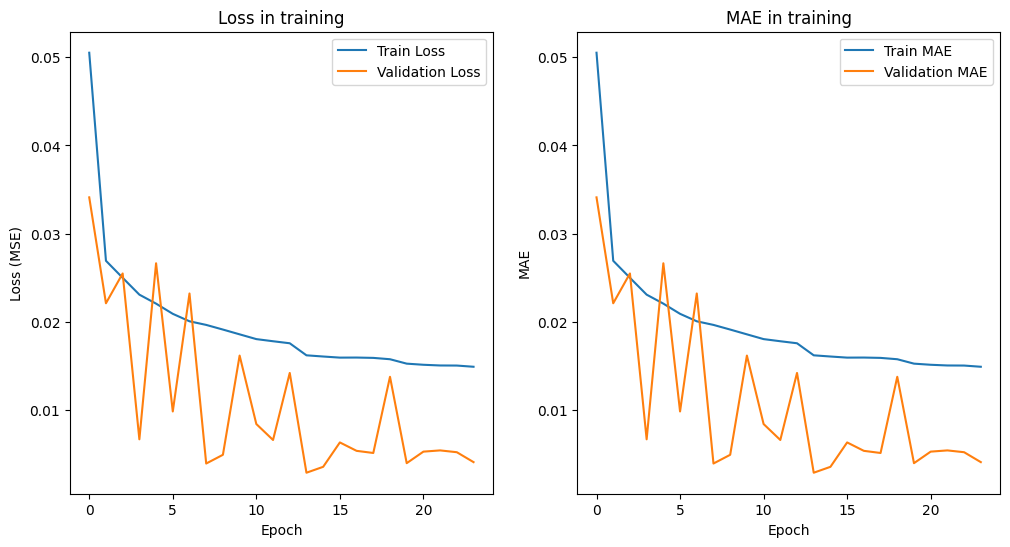

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss in training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE in training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step

معیارهای ارزیابی برای EURUSD_Close:
MSE: 1.5164884261139914e-05
RMSE: 0.003894211635381405
MAE: 0.003449839060863433
R² Score: 0.946271117341462

330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step

معیارهای ارزیابی برای EURUSD_Close:
MSE: 1.0185402589977324e-05
RMSE: 0.0031914577531243185
MAE: 0.00276228323492139
R² Score: 0.963907731904832


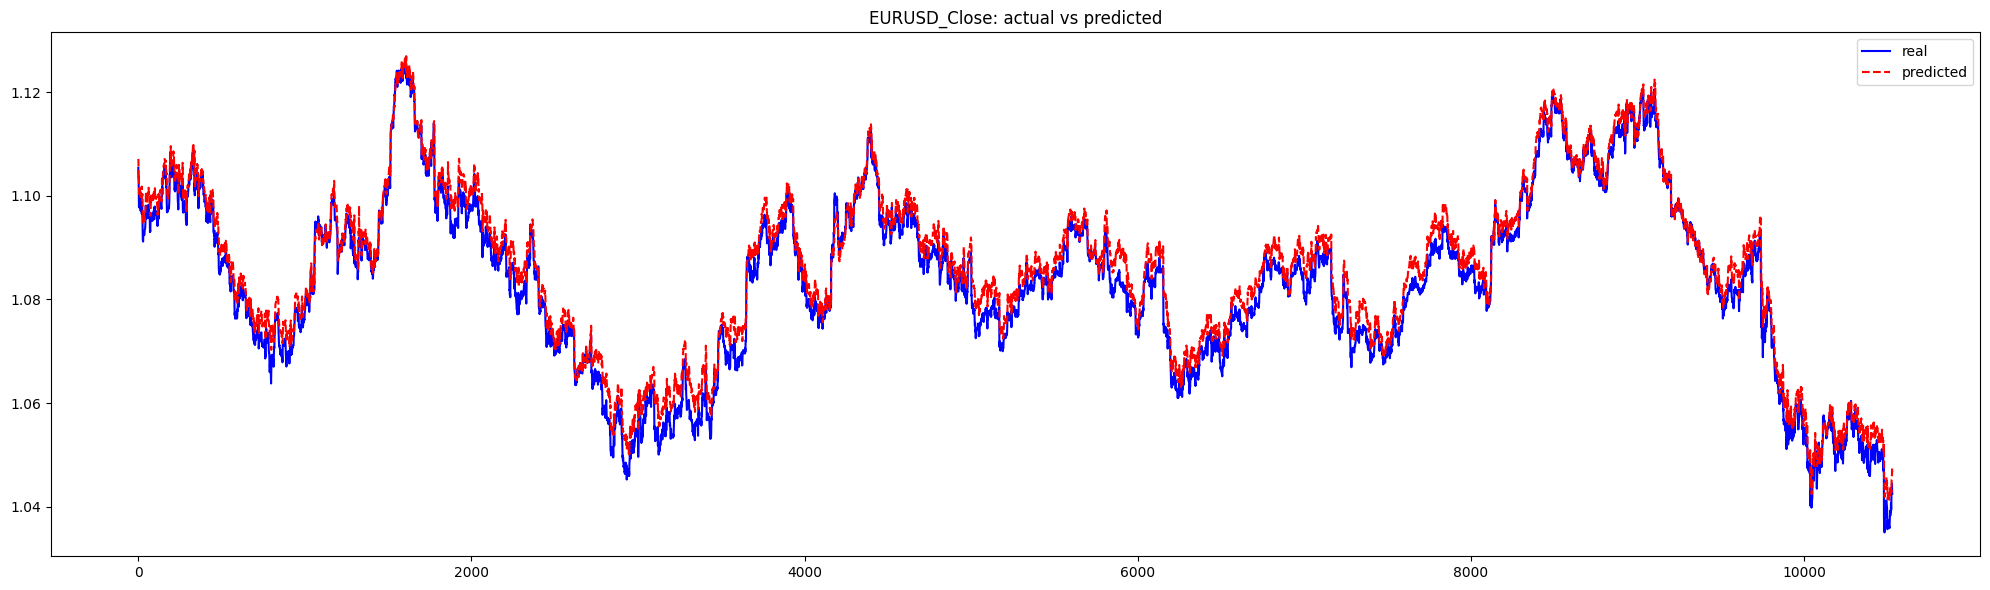

In [18]:
predictions = model.predict(X_test)

# 10. برگردوندن به مقیاس اصلی
predictions_average = scalers_outputs['EURUSD_Close'].inverse_transform(predictions[:, 0].reshape(-1, 1))


y_test_average = scalers_outputs['EURUSD_Close'].inverse_transform(y_test[:, 0].reshape(-1, 1))

# 11. محاسبه معیارها برای هر مقدار
def calculate_metrics(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\nمعیارهای ارزیابی برای {name}:")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R² Score: {r2}")

calculate_metrics(y_test_average, predictions_average, "EURUSD_Close")



# 13. رسم پیش‌بینی‌ها
plt.figure(figsize=(20, 6))
plt.subplot(1, 1, 1)
plt.plot(y_test_average, label='real', color='blue')
plt.plot(predictions_average, label='predicted', color='red',linestyle='--')
plt.title('EURUSD_Close: actual vs predicted')
plt.legend()



plt.tight_layout()
plt.show()

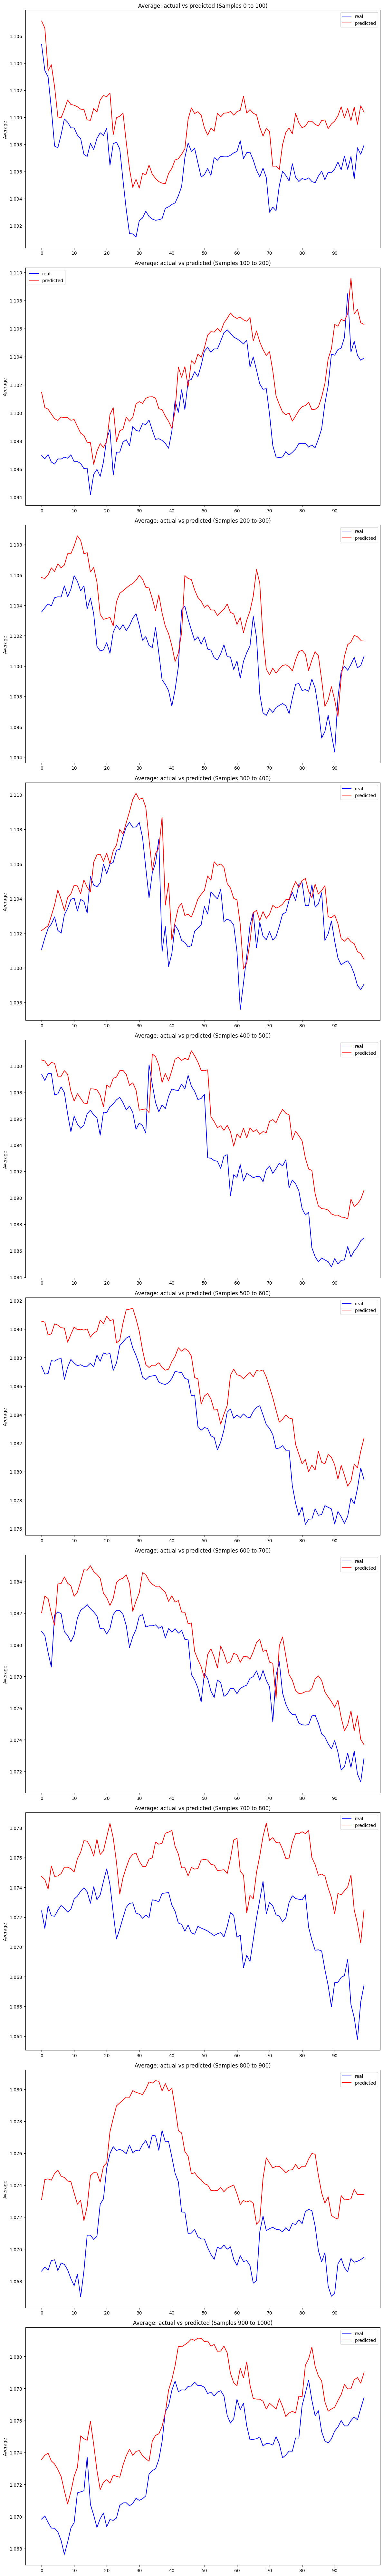

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# فرض می‌کنیم y_test_average و predictions_average آرایه‌های شما هستن
# y_test_average: مقادیر واقعی Average برای داده‌های تست
# predictions_average: مقادیر پیش‌بینی‌شده Average توسط مدل

# تعداد نمونه‌هایی که می‌خوای رسم کنی (1000 نمونه اول)
total_samples = 1000
n_samples_per_plot = 100  # تعداد نمونه‌ها در هر نمودار
n_plots = total_samples // n_samples_per_plot  # تعداد نمودارها (10)

# تنظیمات شکل کلی
plt.figure(figsize=(12, 8 * n_plots))  # ارتفاع شکل رو متناسب با تعداد نمودارها تنظیم می‌کنیم

# حلقه برای رسم 10 نمودار
for i in range(n_plots):
    # محاسبه بازه نمونه‌ها برای هر نمودار
    start_idx = i * n_samples_per_plot
    end_idx = (i + 1) * n_samples_per_plot
    
    # انتخاب داده‌ها برای این بازه
    y_test_subset = y_test_average[start_idx:end_idx]
    predictions_subset = predictions_average[start_idx:end_idx]
    
    # ایجاد زیرنمودار
    plt.subplot(n_plots, 1, i + 1)  # n_plots ردیف، 1 ستون، اندیس i+1
    
    # رسم خطوط
    plt.plot(y_test_subset, label='real', color='blue')
    plt.plot(predictions_subset, label='predicted', color='red')
    
    # اضافه کردن عنوان و لیبل‌ها
    plt.title(f'Average: actual vs predicted (Samples {start_idx} to {end_idx})')
    plt.ylabel('Average')
    plt.legend()
    
    # تنظیم محور x برای نمایش اندیس نمونه‌ها
    plt.xticks(np.arange(0, n_samples_per_plot, 10))  # تیک‌ها هر 10 نمونه

# تنظیمات نهایی و نمایش نمودار
plt.tight_layout()
plt.show()

MAE on Test Data (First 100 Samples): 0.003061119555282592
RMSE on Test Data (First 100 Samples): 0.0032493176471091244


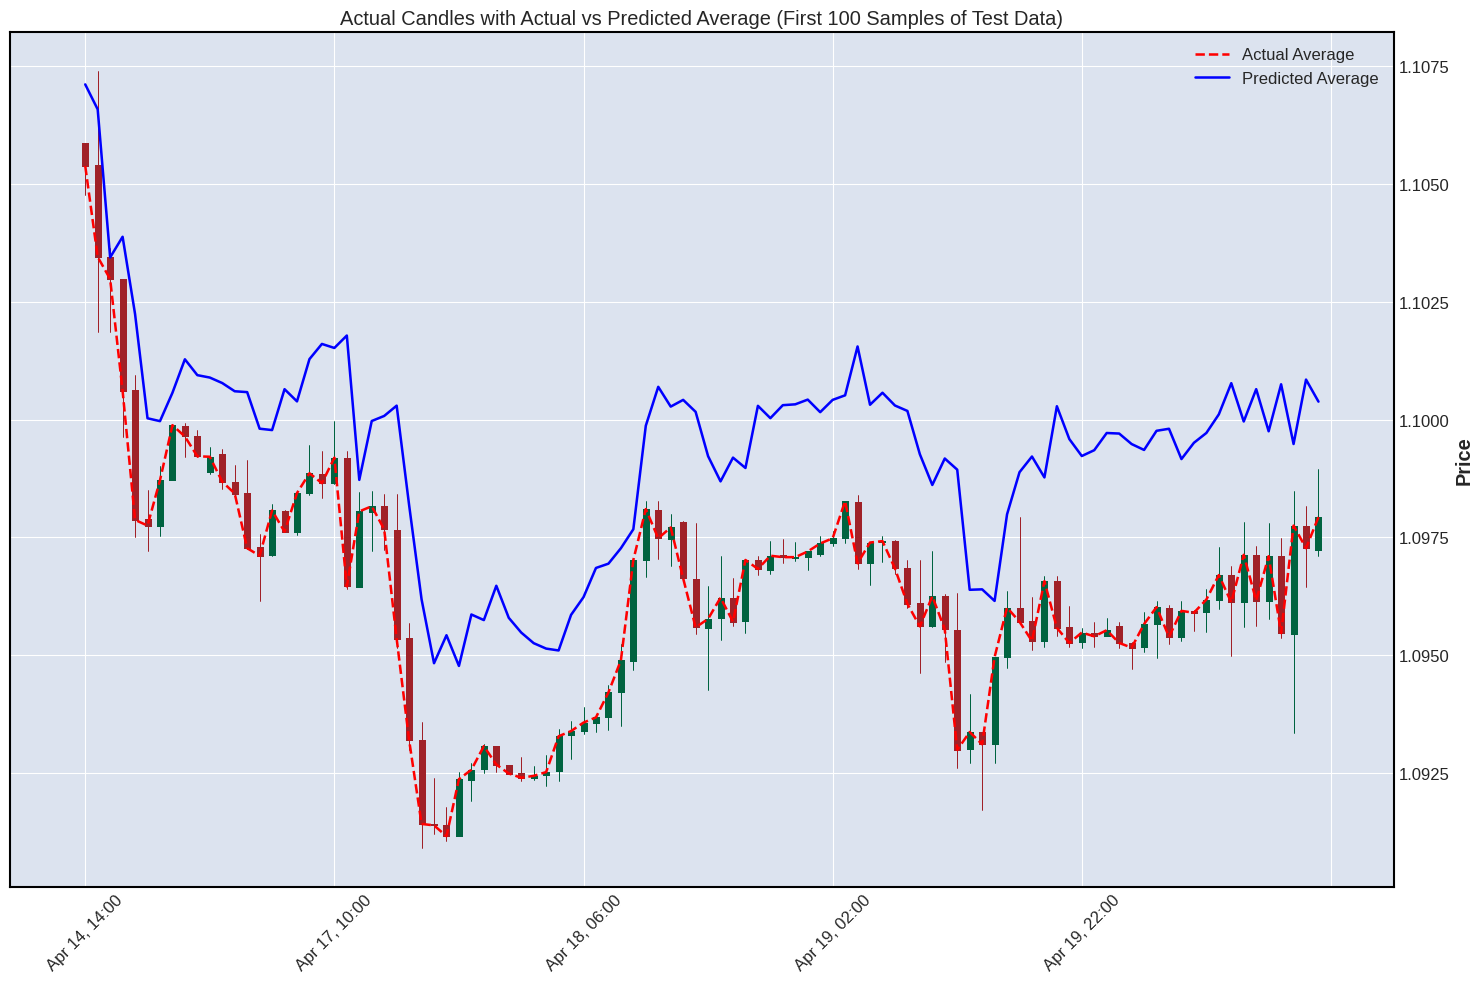

In [20]:
import mplfinance as mpf
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# فرض می‌کنیم data دیتافریم اولیه شماست که ستون‌های EURUSD_Open, EURUSD_High, EURUSD_Low, EURUSD_Close, EURUSD_Average داره
n_test_samples = len(X_test)  # تعداد نمونه‌های تست: 21186

# انتخاب داده‌های تست از دیتافریم data
test_data = df.iloc[-n_test_samples:].copy()
test_data.index = pd.DatetimeIndex(test_data.index)  # اطمینان از اینکه ایندکس به فرمت DatetimeIndex باشه

# محدود کردن تعداد نمونه‌ها برای رسم (100 نمونه اول)
n_samples_to_plot = 100
test_data = test_data.iloc[:n_samples_to_plot]  # 100 نمونه اول

# تغییر نام ستون‌ها به فرمت استاندارد برای mplfinance
test_data_renamed = test_data.rename(columns={
    'EURUSD_Open': 'Open',
    'EURUSD_High': 'High',
    'EURUSD_Low': 'Low',
    'EURUSD_Close': 'Close'
})

# فرض می‌کنیم predictions خروجی مدل شماست و برای داده‌های تست (X_test) هست
predicted_average = predictions.flatten()  # تبدیل به آرایه یک‌بعدی
predicted_average = predicted_average[:n_samples_to_plot]  # محدود کردن به 100 نمونه اول

# اگه predictions نرمال‌سازی‌شده هست، به مقیاس اصلی برمی‌گردونیم
predicted_average = scalers_outputs['EURUSD_Close'].inverse_transform(predicted_average.reshape(-1, 1)).flatten()

# ایجاد یک DataFrame برای Average پیش‌بینی‌شده با همان ایندکس
predicted_df = pd.DataFrame({
    'Predicted_Average': predicted_average
}, index=test_data.index)

# برای مقایسه، Average واقعی رو از test_data می‌گیریم
actual_average = test_data['EURUSD_Close'].values
actual_average_df = pd.DataFrame({
    'Actual_Average': actual_average
}, index=test_data.index)

# محاسبه معیارهای ارزیابی
mae = mean_absolute_error(actual_average, predicted_average)
rmse = np.sqrt(mean_squared_error(actual_average, predicted_average))
print(f"MAE on Test Data (First 100 Samples): {mae}")
print(f"RMSE on Test Data (First 100 Samples): {rmse}")

# تنظیمات برای رسم
fig = mpf.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)

# رسم کندل‌استیک‌ها با دیتافریم تغییر نام داده‌شده
mpf.plot(test_data_renamed, type='candle', style='charles', ax=ax, volume=False)

# اضافه کردن خط Actual Average
ap1 = mpf.make_addplot(actual_average_df['Actual_Average'], type='line', color='red', linestyle='--', ax=ax, label='Actual Average')

# اضافه کردن خط Predicted Average
ap2 = mpf.make_addplot(predicted_df['Predicted_Average'], type='line', color='blue', linestyle='-', ax=ax, label='Predicted Average')

# رسم کندل‌ها با هر دو خط
mpf.plot(test_data_renamed, type='candle', style='charles', ax=ax, volume=False, addplot=[ap1, ap2])

# اضافه کردن عنوان و لیبل‌ها
ax.set_title('Actual Candles with Actual vs Predicted Average (First 100 Samples of Test Data)')
ax.set_ylabel('Price')

# نمایش لجند
ax.legend()

# تنظیمات نهایی و نمایش نمودار
fig.tight_layout()
mpf.show()

In [ ]:
model

In [23]:
del model

In [ ]:
model